<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 2

The goal is to compare `dense neural networks` and `convolutional neural networks` on `Fashion mnist` data.



## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.


Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. `Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. Use

```python
fashion_mnist.load_data()
```

to the get these datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist


In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.datasets import fashion_mnist

### Verify TensorFlow Version and Keras Version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.1.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.2.4-tf


### Establish Expirement Reproducibility

In [4]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Step 1: Loading Fashion MNIST Dataset

Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. It comes prepackaged as part of tf.Keras. Use the `tf.keras.datasets.fashion_mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## Step 2: EDA Training and Test Datasets

* Imported 60000 examples for training and 10000 examples for test 
* Imported 60000 labels for training and 10000 labels for test 

In [6]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t\t{}'.format(test_images.shape))
print('test_labels:\t\t{}'.format(test_labels.shape))

train_images:	(60000, 28, 28)
train_labels:	(60000,)
test_images:		(10000, 28, 28)
test_labels:		(10000,)


### Review labels for training dataset

In [7]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [9 0 0 3 0 2 7 2 5 5]

This output the numeric label, need to convert to item description


### Find frequency of each label in the training and test data

In [8]:
# from collections import Counter
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [9]:
Counter(test_labels).most_common()

[(9, 1000),
 (2, 1000),
 (1, 1000),
 (6, 1000),
 (4, 1000),
 (5, 1000),
 (7, 1000),
 (3, 1000),
 (8, 1000),
 (0, 1000)]

### Plot Examples

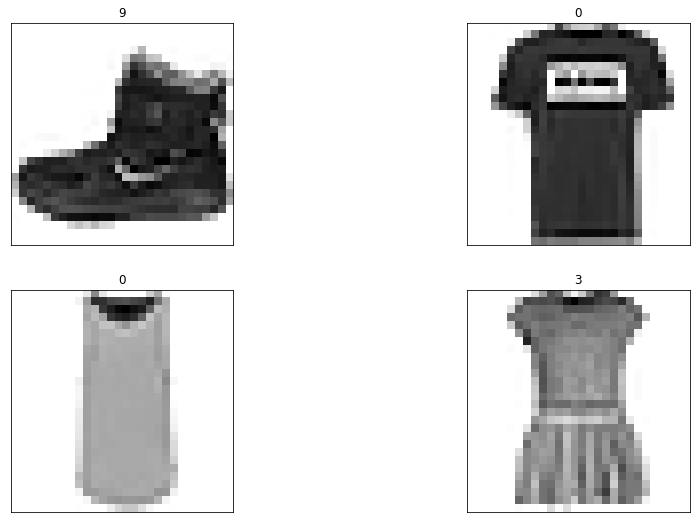

In [10]:
%matplotlib inline
fig = plt.figure(figsize = (15, 9))

for i in range(4):
    plt.subplot(2, 2, 1+i)
    plt.title(train_labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i].reshape(28,28), cmap='binary')

## Step 3: Preprocessing Data for Model Development

### Preprocessing the Examples

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	T-shirt/top  |
|1|	Trouser      |
|2|	Pullover     |
|3|	Dress        |
|4|	Coat         |
|5|	Sandal       |
|6|	Shirt        |
|7|	Sneaker      |
|8|	Bag          |
|9|	Ankle boot   |

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

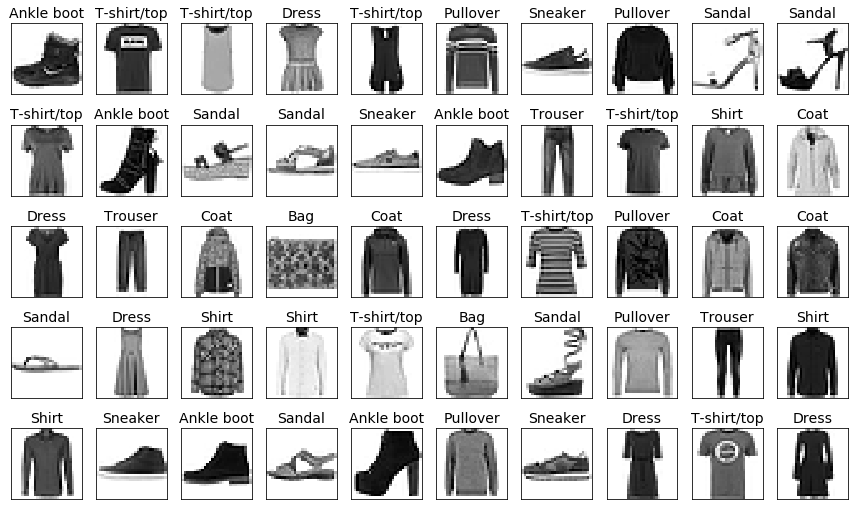

In [12]:
%matplotlib inline
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(class_names[train_labels[i]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i].reshape(28,28), cmap='binary')

### Preprocessing the Examples
 The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = white
4. 255 = black

In [13]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(train_images[0]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

In [14]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images_norm = train_images.astype('float32')/255.

test_images = test_images.reshape((10000, 28, 28, 1))
test_images_norm = test_images.astype('float32')/255.

## Validating our approach

10,000 samples of our training data to use as a validation set. 

In [15]:
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]

In [16]:
val_images_norm.shape, val_labels.shape

((10000, 28, 28, 1), (10000,))

## Step 4: Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNNarchitecture2.png?raw=1">

### Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 4 layers Conv2D and MaxPooling handle feature learning.  The last 3 layers, handle classification.  

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1639424   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

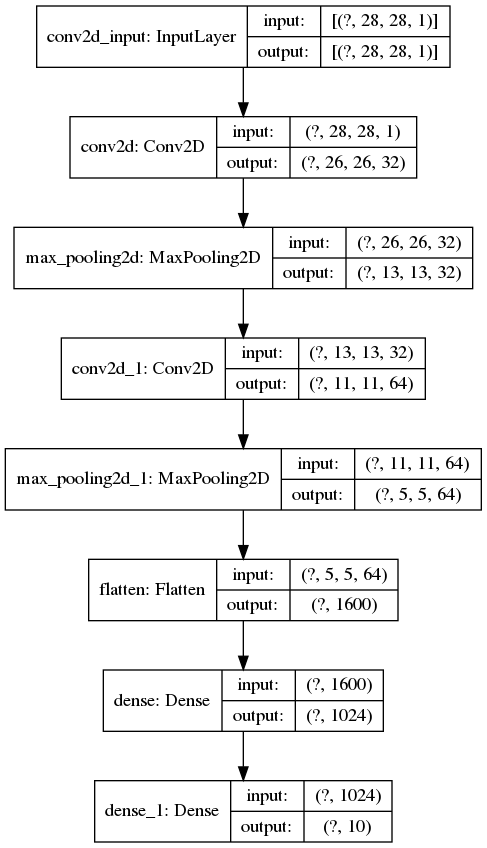

In [19]:
keras.utils.plot_model(model, "FashionMnist_model.png", show_shapes=True) 

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Step 5: Training the model

In [21]:
history = model.fit(train_images_norm,
                    train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_images_norm,val_labels)
                   )

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 46s 914us/sample - loss: 1.7682 - accuracy: 0.7081 - val_loss: 1.6751 - val_accuracy: 0.7901
Epoch 2/20
50000/50000 [==============================] - 44s 886us/sample - loss: 1.6550 - accuracy: 0.8103 - val_loss: 1.6413 - val_accuracy: 0.8237
Epoch 3/20
50000/50000 [==============================] - 44s 887us/sample - loss: 1.6252 - accuracy: 0.8399 - val_loss: 1.6179 - val_accuracy: 0.8452
Epoch 4/20
50000/50000 [==============================] - 44s 886us/sample - loss: 1.6096 - accuracy: 0.8549 - val_loss: 1.6037 - val_accuracy: 0.8583
Epoch 5/20
50000/50000 [==============================] - 45s 892us/sample - loss: 1.5983 - accuracy: 0.8653 - val_loss: 1.5990 - val_accuracy: 0.8644
Epoch 6/20
50000/50000 [==============================] - 44s 887us/sample - loss: 1.5892 - accuracy: 0.8739 - val_loss: 1.5896 - val_accuracy: 0.8716
Epoch 7/20
50000/50000 [====================

validation_data = Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data

## Step 6: Test the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [22]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

10000/10000 [==============================] - 4s 407us/sample - loss: 1.5634 - accuracy: 0.8980
test set accuracy:  89.80000019073486


## Task 7: Predictions

In [23]:
preds = model.predict(test_images_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


## Task 8: Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

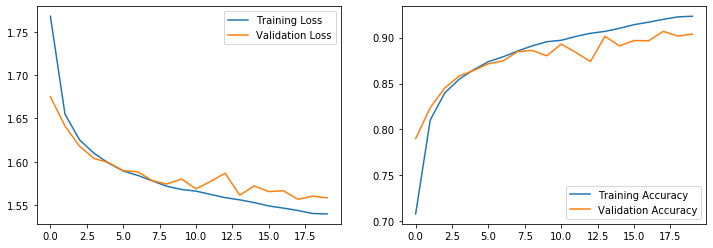

In [26]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Task 9: Creating confusion matrices

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [27]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(train_images_norm), axis=-1)
pred_classes

array([8, 7, 6, ..., 3, 0, 5])

In [28]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[4483,   14,   41,   66,    6,    1,  422,    0,   25,    0],
       [   5, 4916,    0,   42,    4,    0,    2,    0,    4,    0],
       [  33,    7, 4040,   35,  322,    0,  539,    0,    8,    0],
       [  71,   22,   16, 4682,   71,    0,  113,    0,    3,    3],
       [   3,   18,   98,  120, 4448,    0,  334,    0,    3,    2],
       [   0,    0,    0,    0,    0, 4911,    0,   52,    4,   44],
       [ 426,   20,  145,   83,  179,    0, 4113,    0,   12,    1],
       [   0,    0,    0,    0,    0,   17,    0, 4831,    1,  129],
       [  11,    3,   13,    8,   12,    3,   30,    5, 4923,    2],
       [   0,    0,    0,    0,    0,    8,    0,   86,    3, 4903]], dtype=int32)>

|Label  |Class_  |
|-------|--------|
|0|	T-shirt/top  |
|1|	Trouser      |
|2|	Pullover     |
|3|	Dress        |
|4|	Coat         |
|5|	Sandal       |
|6|	Shirt        |
|7|	Sneaker      |
|8|	Bag          |
|9|	Ankle boot   |

### Visualizing the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

Looks like 28 fours were misclassified as nines (and 10 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.

In [29]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

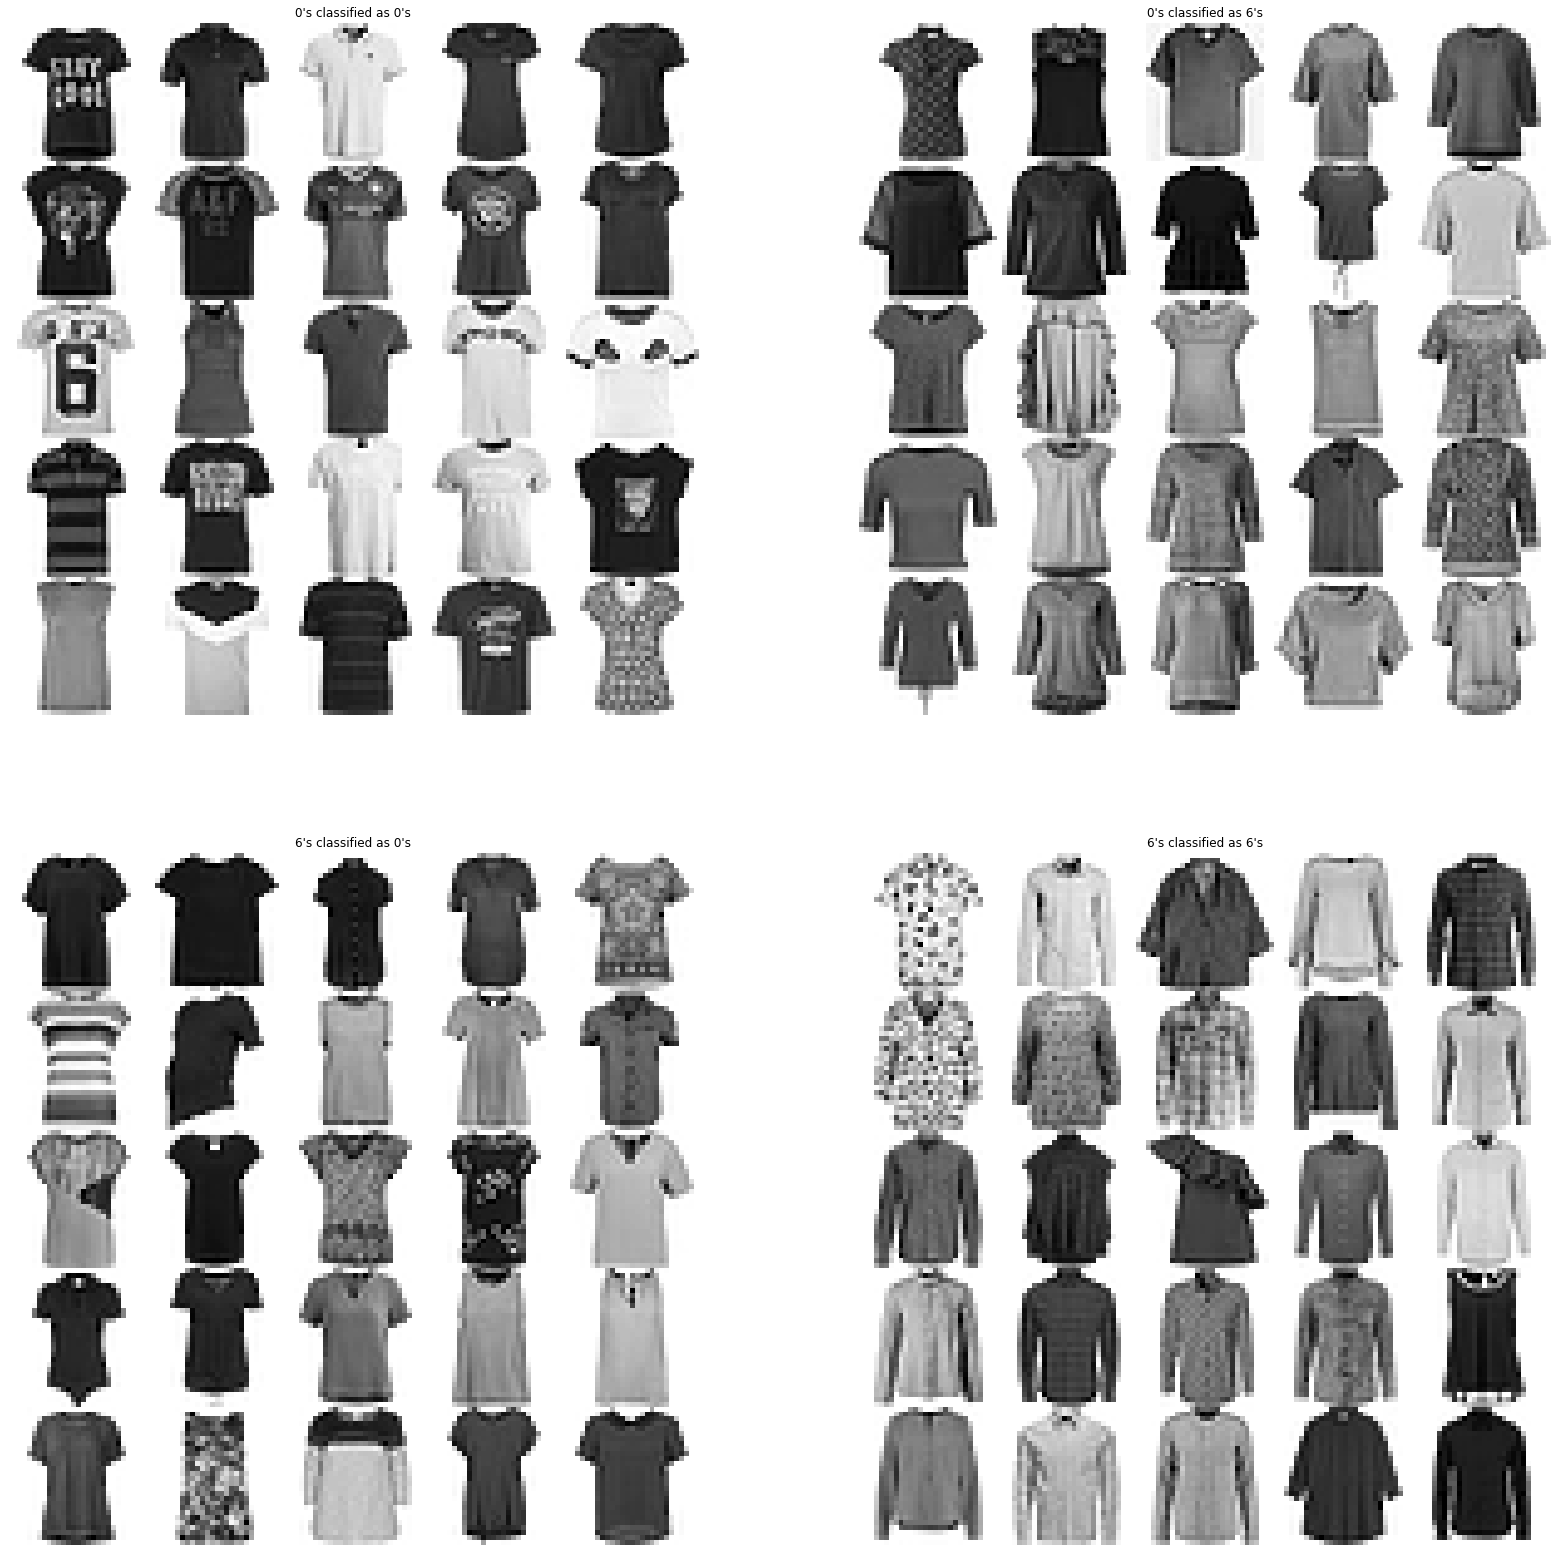

In [30]:
cl_a, cl_b = 0, 6
X_aa = train_images_norm[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images_norm[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images_norm[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images_norm[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(28,28))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

plt.show()

|Label  |Class_  |
|-------|--------|
|0|	T-shirt/top  |
|1|	Trouser      |
|2|	Pullover     |
|3|	Dress        |
|4|	Coat         |
|5|	Sandal       |
|6|	Shirt        |
|7|	Sneaker      |
|8|	Bag          |
|9|	Ankle boot   |

In [31]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,1.548777,0.91414,1.565364,0.8969
16,1.546314,0.91688,1.566374,0.8966
17,1.543521,0.91996,1.556445,0.9068
18,1.540074,0.92260,1.560175,0.9017
19,1.539597,0.92332,1.558188,0.9039


### Image Data Augumentation

https://www.kaggle.com/imrandude/fashion-mnist-cnn-imagedatagenerator

In [32]:
# https://www.kaggle.com/imrandude/fashion-mnist-cnn-imagedatagenerator
shift_fraction=0.005
batch_size = 512
num_classes = test_images.shape[1]
epochs = 10

gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=shift_fraction,height_shift_range=shift_fraction,horizontal_flip=True)
batches = gen.flow(train_images_norm, train_labels, batch_size=batch_size)
val_batches = gen.flow(val_images_norm, val_labels, batch_size=batch_size)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fashion_train=\
model.fit(batches, steps_per_epoch=\
                    train_images_norm.shape[0]//batch_size, epochs=epochs,validation_data=val_batches, 
                            validation_steps=val_images_norm.shape[0]//batch_size, use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 97 steps, validate for 19 steps
Epoch 1/10
97/97 [==============================] - 51s 530ms/step - loss: 1.6125 - accuracy: 0.8502 - val_loss: 1.6106 - val_accuracy: 0.8513
Epoch 2/10
97/97 [==============================] - 49s 508ms/step - loss: 1.5974 - accuracy: 0.8652 - val_loss: 1.6067 - val_accuracy: 0.8547
Epoch 3/10
97/97 [==============================] - 49s 506ms/step - loss: 1.5945 - accuracy: 0.8677 - val_loss: 1.6047 - val_accuracy: 0.8571
Epoch 4/10
97/97 [==============================] - 49s 508ms/step - loss: 1.5914 - accuracy: 0.8711 - val_loss: 1.6088 - val_accuracy: 0.8522
Epoch 5/10
97/97 [==============================] - 49s 506ms/step - loss: 1.5916 - accuracy: 0.8705 - val_loss: 1.5981 - val_accuracy: 0.8620
Epoch 6/10
97/97 [==============================] - 49s 507ms/step - loss: 1.5843 - accuracy: 0.8779 - val_loss: 1.5965 - val_accuracy: 0.8661
Epoch 7/10
97/97 [==============================] 

In [33]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

10000/10000 [==============================] - 4s 392us/sample - loss: 1.5546 - accuracy: 0.9073
test set accuracy:  90.72999954223633
